In [1]:
from IPython.display import Image as IImage
from IPython.display import HTML
import requests
from datetime import datetime, timedelta
import time
from PIL import Image
from __future__ import print_function
import base64
import cv2
import numpy as np
from __future__ import division

In [2]:
scale_base = {
    0  : np.array([0xff, 0xff, 0xff]),
    1  : np.array([0xe4, 0xe5, 0xff]),
    11 : np.array([0x4d, 0x5d, 0xff]),
    21 : np.array([0x00, 0x07, 0x70]),
    25 : np.array([0x00, 0x07, 0x70]),
    26 : np.array([0xfe, 0x16, 0x00]),
    31 : np.array([0xfe, 0x16, 0x00]),
    41 : np.array([0xc0, 0x1c, 0xc4]),
}

scale = np.empty((42, 3), dtype=int)
for i in range(42):
    start_pos = max([j for j in scale_base.keys() if j <= i])
    start = scale_base[start_pos]
    stop_pos = min([j for j in scale_base.keys() if j >= i])
    stop = scale_base[stop_pos]
    
    delta = stop_pos - start_pos
    if delta == 0:
        scale[i] = start
        continue
    ti = i - start_pos
    dist = ti/delta
    color = np.array(np.sqrt((1-dist) * start ** 2 + dist * stop ** 2), dtype=int)
    scale[i] = color

In [3]:
spans = ['<span style="background-color: #{:02x}{:02x}{:02x}; width: 1.5em; height: 3em; display: inline-block;">{}</span>'.format(r,g,b, i) for i,(r, g, b) in enumerate(scale)]
HTML(data="".join(spans))

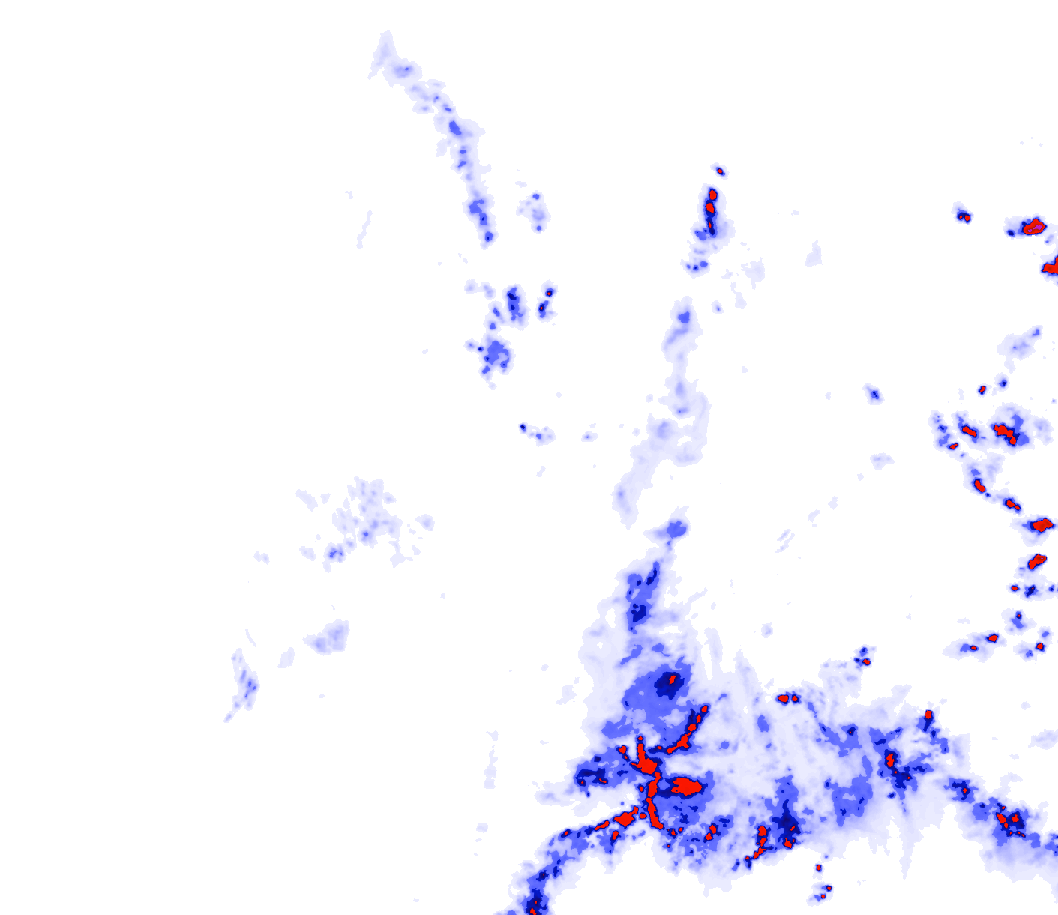

In [4]:
now = datetime.utcnow()
delta = timedelta(minutes=(- now.minute % 5))
frame_time = now + delta
timestr = frame_time.strftime("%Y%m%d%H%M")
r = requests.get("http://api.buienradar.nl/image/1.0/webmercatorradarnl/png/?t=%s" % timestr)
IImage(r.content)

In [5]:
N = 34
!mkdir -p raw
now = datetime.utcnow()
delta = timedelta(minutes=(- now.minute % 5))
frame_time = now + delta
for i in range(N):
    time.sleep(0.1)
    t = frame_time + i * timedelta(minutes=5)
    timestr = t.strftime("%Y%m%d%H%M")
    r = requests.get("http://api.buienradar.nl/image/1.0/webmercatorradarnl/png/?t=%s" % timestr)
    if r.ok:
        with open("raw/%05i.png" % i, 'wb') as f:
            f.write(r.content)
        print(".", end="")
    else:
        break

..................................

In [6]:
%%time
!mkdir -p gray
for i in range(N):
    image = np.array(Image.open("raw/%05i.png" % i))
    res = np.empty(image.shape[:2], dtype=np.uint8)
    for y in range(res.shape[0]):
        for x in range(res.shape[1]):
            pix = image[y][x]
            if pix[3] == 0:
                res[y][x] = 0
            else:
                res[y][x] = np.linalg.norm(scale - pix[:3], axis=1).argmin() * 5
    
    r = Image.fromarray(res)
    r.save("gray/%05i.png" % i)

CPU times: user 2min 13s, sys: 56.2 ms, total: 2min 13s
Wall time: 2min 13s


In [21]:
!mkdir -p mov
! ffmpeg -f image2 -r 2.5 -i gray/%05d.png mov/gray.mp4 -y 2> /dev/null
! ffmpeg -f image2 -r 2.5 -i gray/%05d.png mov/gray.webm -y 2> /dev/null

In [8]:
def video(b, mime="video/mp4"):
    encoded = base64.b64encode(b)
    return HTML(data='''<video alt="test" controls>
                    <source src="data:{0};base64,{1}" type="{2}" />
                 </video>'''.format(mime,encoded.decode('ascii'),mime))

In [9]:
%%time

cap = cv2.VideoCapture("mov/gray.mp4")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

flows = []

for _ in range(N-1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, 0.0, 1, 3, 15, 3, 5, 1, 0)
    flows.append(flow)

    prvs = next

cap.release()

CPU times: user 22.4 s, sys: 468 ms, total: 22.9 s
Wall time: 22.5 s


In [10]:


init = flows[0]
coords = np.empty_like(init, int)
for y in range(flow.shape[0]):
    for x in range(flow.shape[1]):
        coords[y][x][0] = x
        coords[y][x][1] = y


In [11]:
cap = cv2.VideoCapture("mov/gray.mp4")

frames = []
for t in range(N):
    ret, frame2 = cap.read()
    frames.append(frame2)


In [12]:
%%time
NFRAMES = 5

new_frames = []
for t in range(N-1):
    print("\n#", end="")
    t0 = 0
    t1 = t0 + 1
    flow = flows[t]
    f0 = frames[t]
    f1 = frames[t+1]
    new_frames.append(f0)
    for ti in np.linspace(0, 1, NFRAMES + 1, endpoint=False)[1:]:
        print(".", end="")
        back = np.array(coords) - ti * flow
        forward = np.array(coords) + (1-ti) * flow
        frame = np.empty_like(f0)
        for y in range(frame.shape[0]):
            for x in range(frame.shape[1]):
                    xb, yb = back[y][x]
                    xf, yf = forward[y][x]
                    xb = max(min(xb, frame.shape[1] - 1),0)
                    xf = max(min(xf, frame.shape[1] - 1),0)
                    yb = max(min(yb, frame.shape[0] - 1),0)
                    yf = max(min(yf, frame.shape[0] - 1),0)
                    frame[y][x] = (1-ti) * f0[yb][xb] + ti * f1[yf][xf]
        new_frames.append(frame)
new_frames.append(frames[-1])


#.

/home/nikita/Code/pluie/ve/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....
#.....CPU times: user 44min 23s, sys: 539 ms, total: 44min 24s
Wall time: 44min 24s


In [13]:
!mkdir -p interpolate
!rm -f interpolate/*
for i,frame in enumerate(new_frames):
    cv2.imwrite("interpolate/%05i.png" % i, frame)
    

In [22]:
! ffmpeg -f image2 -r 15 -i interpolate/%05d.png mov/int.mp4 -y 2> /dev/null
! ffmpeg -f image2 -r 15 -i interpolate/%05d.png mov/int.webm -y 2> /dev/null